# Assignment 4: CNN

## Description

Implement a Convolutional Neural Network (CNN) classifier to predict whether a given icon image is the real / fake.

- You are not required to use Colab in this assignment, but you have to **submit your source code**.

## Dataset

- https://lab.djosix.com/icons.zip
- 64x64 RGB jpg images


```
real/           (10000 images)
    0000.jpg
    0001.jpg
    ...
    9999.jpg
fake/           (10000 images)
    0000.jpg
    0001.jpg
    ...
    9999.jpg
unknown/        (5350 images, testing set)
    0000.jpg
    0001.jpg
    ...
    5349.jpg
```

- Training set
  - 20000 icons in `real/` and `fake/`
  - You should predict 1 for icons in `real/` and 0 for icons in `fake/`
- Testing set:
  - 5350 icons in `unknown/`
  - Your score depends on the **accuracy** on this testing set,  
    so the prediction of each icon in `unknown/` should be submitted (totally 5350 predictions, see below).


## Submission

Please upload **2 files** to E3. (`XXXXXXX` is your student ID)

1. **`XXXXXXX_4_result.json`**  
  This file contains your model prediction for the testing set.  
  You must generate this file with the function called `save_predictions()`.
2. **`XXXXXXX_4_source.zip`**  
  Zip your source code into this archive.


## Hints

- **Deep Learning Libraries**: You can use any deep learning frameworks (PyTorch, TensorFlow, ...).
- **How to implement**: There are many CNN examples for beginners on the internet, e.g. official websites of the above libraries, play with them and their model architectures to abtain high accuracy on testing set.
- **GPU/TPU**: Colab provides free TPU/GPU for training speedup, please refer to [this page in `pytut.pdf` on E3](https://i.imgur.com/VsrUh7I.png).


### Include this in your code to generate result file

In [1]:
import json

def save_predictions(student_id, predictions):
  # Please use this function to generate 'XXXXXXX_4_result.json'
  # `predictions` is a list of int (0 or 1; fake=0 and real=1)
  # For example, `predictions[0]` is the prediction given "unknown/0000.jpg".
  # it will be 1 if your model think it is real, else 0 (fake).

  assert isinstance(student_id, str)
  assert isinstance(predictions, list)
  assert len(predictions) == 5350

  for y in predictions:
    assert y in (0, 1)

  with open('{}_4_result.json'.format(student_id), 'w') as f:
    json.dump(predictions, f)

**PyTorch**

In [2]:
parameters = {
    "batch_size" : 128,
    "epoch" : 30,
    "val_size" : 1000,
    "unk_size" : 5350
}

In [3]:
# Link to google drive
from google.colab import drive
drive.mount('/content/drive')

!pip install -U -q PyDrive
!ls /content/drive/MyDrive/Colab\ Notebooks/HW4/icons

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fake  real


In [4]:
import os
import numpy as np
import pandas as pd

import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Now using device =", device)

Now using device = cuda:0


In [42]:
# Creating Data Set

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

def show_img(img, lab):
    print(f"Label : {dataset.classes[lab]}")
    plt.imshow(img.permute(1, 2, 0))

data_dir = "/content/drive/MyDrive/Colab Notebooks/HW4/icons/"
test_dir = "/content/drive/MyDrive/Colab Notebooks/HW4/unknown"

dataset = ImageFolder(data_dir, transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor()                                                             
]))
# testData = ImageFolder(test_dir, transform = transforms.Compose([ 
#     transforms.Resize((64, 64)),
#     transforms.ToTensor()                                                             
# ]))

print("Classes: ", dataset.classes) 

Classes:  ['fake', 'real']


In [6]:
# Split dataset 
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = parameters["batch_size"]
val_size = parameters["val_size"]
tra_size = len(dataset) - val_size

tra_data, val_data = random_split(dataset, [tra_size, val_size])
print("Trainning Data:", len(tra_data))
print("Validation Data:", len(val_data))

tra_dl = DataLoader(tra_data, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, shuffle = False, num_workers = 2, pin_memory = True)

Trainning Data: 19000
Validation Data: 1000


In [7]:
# Visualize Batch image

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def display_batch(dl):
    for img, lab in dl:
        fig, ax = plt.subplots(figsize = (16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(img, nrow = 16).permute(1,2,0))
        break

# display_batch(tra_dl)

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        imgs, labs = batch
        imgs, labs = imgs.cuda(), labs.cuda()
        prdt = self(imgs)
        loss = F.cross_entropy(prdt, labs)
        return loss
    
    def validation_step(self, batch):
        imgs, labs = batch
        imgs, labs = imgs.cuda(), labs.cuda()
        prdt = self(imgs)
        loss = F.cross_entropy(prdt, labs)
        accy = accuracy(prdt, labs)
        
        return { 
            'val_loss' : loss.detach(), 
            'val_accy' : accy 
        }
    

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        
        batch_accs = [x['val_accy'] for x in outputs]
        epoch_accy = torch.stack(batch_accs).mean()     # Combine accuray

        return { 
            'val_loss' : epoch_loss.item(), 
            'val_accy' : epoch_accy.item() 
        }


    def print_epoch_res(self, result):
        print("Tra_loss: {:.4f}".format(result['train_loss']))
        print("Val_loss: {:.4f}".format(result['val_loss']))
        print("Accuracy: {:.4f}".format(result['val_accy']), end = "\n\n")

In [9]:
class RealFakeClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(16384,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, x):
        return self.network(x)

In [10]:
# Use for tqdm notebook -> progress status
from tqdm.notebook import tqdm

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad() # Not to calculate gradient(faster)
def evaluate(model, val_loader):
    model.eval()

    outputs = []
    for batch in tqdm(val_loader):
        outputs.append(model.validation_step(batch))
    
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, tra_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        print("Epoch ", epoch, ":") 

        model.train()
        train_losses = []
        for batch in tqdm(tra_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        
        model.print_epoch_res(result)
        history.append(result)
    
    return history

In [12]:
num_eph = parameters["epoch"]
opt_fuc = torch.optim.Adam      # or torch.optim.SGD
lr = 0.001

model = RealFakeClassification().to(device)

# fitting the model on training data and record the result after each epoch
print("Fiting Begin:")
print("Epoch =", num_eph, "Batch =", batch_size, "Validation Size =", val_size, end = "\n\n")

history = fit(num_eph, lr, model, tra_dl, val_dl, opt_fuc)

Fiting Begin:
Epoch = 30 Batch = 128 Validation Size = 1000

Epoch  0 :



Tra_loss: 0.8408
Val_loss: 0.6972
Accuracy: 0.4934

Epoch  1 :



Tra_loss: 0.6956
Val_loss: 0.6940
Accuracy: 0.4934

Epoch  2 :



Tra_loss: 0.6962
Val_loss: 0.6649
Accuracy: 0.6209

Epoch  3 :



Tra_loss: 0.6763
Val_loss: 0.6182
Accuracy: 0.6482

Epoch  4 :



Tra_loss: 0.6342
Val_loss: 0.5893
Accuracy: 0.7034

Epoch  5 :



Tra_loss: 0.6013
Val_loss: 0.5537
Accuracy: 0.7293

Epoch  6 :



Tra_loss: 0.5587
Val_loss: 0.5139
Accuracy: 0.7529

Epoch  7 :



Tra_loss: 0.4986
Val_loss: 0.4635
Accuracy: 0.7870

Epoch  8 :



Tra_loss: 0.4383
Val_loss: 0.3959
Accuracy: 0.8219

Epoch  9 :



Tra_loss: 0.3798
Val_loss: 0.4421
Accuracy: 0.8041

Epoch  10 :



Tra_loss: 0.3380
Val_loss: 0.2280
Accuracy: 0.9064

Epoch  11 :



Tra_loss: 0.2525
Val_loss: 0.2548
Accuracy: 0.8909

Epoch  12 :



Tra_loss: 0.1829
Val_loss: 0.1669
Accuracy: 0.9369

Epoch  13 :



Tra_loss: 0.1680
Val_loss: 0.1401
Accuracy: 0.9405

Epoch  14 :



Tra_loss: 0.1135
Val_loss: 0.1648
Accuracy: 0.9264

Epoch  15 :



Tra_loss: 0.1405
Val_loss: 0.0902
Accuracy: 0.9734

Epoch  16 :



Tra_loss: 0.0709
Val_loss: 0.0599
Accuracy: 0.9778

Epoch  17 :



Tra_loss: 0.0762
Val_loss: 0.0942
Accuracy: 0.9654

Epoch  18 :



Tra_loss: 0.0619
Val_loss: 0.0861
Accuracy: 0.9691

Epoch  19 :



Tra_loss: 0.0450
Val_loss: 0.1094
Accuracy: 0.9591

Epoch  20 :



Tra_loss: 0.0738
Val_loss: 0.0520
Accuracy: 0.9812

Epoch  21 :



Tra_loss: 0.0306
Val_loss: 0.0461
Accuracy: 0.9859

Epoch  22 :



Tra_loss: 0.0420
Val_loss: 0.0559
Accuracy: 0.9812

Epoch  23 :



Tra_loss: 0.0276
Val_loss: 0.1406
Accuracy: 0.9573

Epoch  24 :



Tra_loss: 0.0181
Val_loss: 0.1232
Accuracy: 0.9683

Epoch  25 :



Tra_loss: 0.0476
Val_loss: 0.0398
Accuracy: 0.9890

Epoch  26 :



Tra_loss: 0.0139
Val_loss: 0.0490
Accuracy: 0.9820

Epoch  27 :



Tra_loss: 0.0101
Val_loss: 0.0670
Accuracy: 0.9790

Epoch  28 :



Tra_loss: 0.0657
Val_loss: 0.0635
Accuracy: 0.9822

Epoch  29 :



Tra_loss: 0.0175
Val_loss: 0.0399
Accuracy: 0.9900



In [63]:
from os import listdir
from os.path import join
from PIL import Image

@torch.no_grad()
def calculateUnknown() -> list:
    prd = []

    # num = 50
    # test_dir = "/content/drive/MyDrive/Colab Notebooks/HW4/icons/real/"
    # imgs_nam = listdir("/content/drive/MyDrive/Colab Notebooks/HW4/icons/real/")

    num = parameters['unk_size']

    imgs_nam = listdir(test_dir)
    loader = transforms.Compose([ 
        transforms.Resize((64, 64)),
        transforms.ToTensor()                                                             
    ])

    model.eval()

    for i in tqdm(imgs_nam):
        dir = join(test_dir, i)
        img = Image.open(dir).convert('RGB')
        img = loader(img)
        img = img.cuda()

        now = model(img[None, ...])
        now = torch.argmax(now, 1).item()
        prd.append(now)

    return prd

tmp = calculateUnknown()
save_predictions("0816153", tmp)

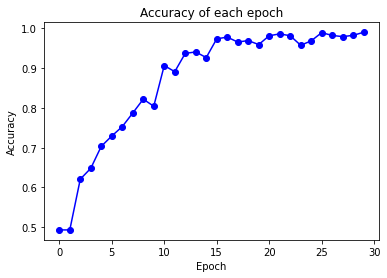

In [26]:
def plot_accuracy(history):
    acc = [x['val_accy'] for x in history]
    plt.plot(acc, '-bo')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of each epoch')

plot_accuracy(history)

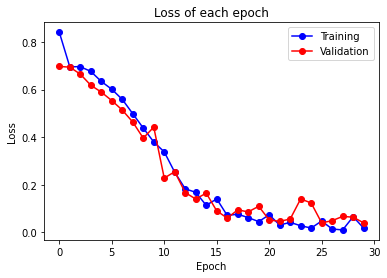

In [27]:
def plot_loss(history):
    tra_los = [x.get('train_loss') for x in history]
    val_los = [x['val_loss'] for x in history]

    plt.plot(tra_los, '-bo')
    plt.plot(val_los, '-ro')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss of each epoch')

plot_loss(history)

**Ref:**


*   [cosmetics classification](https://daniel820710.medium.com/機器學習從零到一-day3-pytorch-介紹與範例-cosmetics-classification-6e826fbce59b)
*   [CNN Model With PyTorch For Image Classification](https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48)


